In [2]:
import pandas as pd

from definitions import OIL_FILE, HOLIDAY_EVENTS_FILE, TRAIN_FILE

oil_df = pd.read_csv(OIL_FILE, parse_dates=['date'])
print(oil_df.head())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


## Dates
inspecting the date column

In [3]:
from EDA.analysis import get_missing_dates

print(oil_df['date'].describe(datetime_is_numeric=True))

print(f"has nans: {oil_df['date'].hasnans}")
missing_dates = get_missing_dates(oil_df['date'])
print(f'There are {len(missing_dates)} missing dates.')
print('Lets see which weekdays:')
print(missing_dates.weekday.unique())

count                   1218
mean     2015-05-02 12:00:00
min      2013-01-01 00:00:00
25%      2014-03-03 06:00:00
50%      2015-05-02 12:00:00
75%      2016-06-30 18:00:00
max      2017-08-31 00:00:00
Name: date, dtype: object
has nans: False
There are 486 missing dates.
Lets see which weekdays:
Int64Index([5, 6], dtype='int64')


The dates range from 2013-01-01 to 2017-08-31
There are no nans but the weekend days are missing as the market is probably closed.

In [4]:
## prices
print(oil_df['dcoilwtico'].describe())
print(oil_df['dcoilwtico'].hasnans)
print(oil_df['dcoilwtico'].isna().sum())

count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64
True
43


Prices range from 26 to 110 and there seem to be some days without a valid price, perhaps they are holidays.

In [9]:
dates_with_nan_price = oil_df[oil_df['dcoilwtico'].isna()].date
holiday_df = pd.read_csv(HOLIDAY_EVENTS_FILE, parse_dates=['date'])
holiday_dates = holiday_df['date'].unique()

# Some dates with NaN prices that are holidays.
print(dates_with_nan_price.isin(holiday_dates).value_counts())

# For the remaining dates it is unknown why the price is missing.
print(dates_with_nan_price[~dates_with_nan_price.isin(holiday_dates)])

False    26
True     17
Name: date, dtype: int64
14     2013-01-21
34     2013-02-18
63     2013-03-29
104    2013-05-27
132    2013-07-04
174    2013-09-02
237    2013-11-28
274    2014-01-20
294    2014-02-17
364    2014-05-26
434    2014-09-01
497    2014-11-27
534    2015-01-19
624    2015-05-25
699    2015-09-07
757    2015-11-26
794    2016-01-18
814    2016-02-15
889    2016-05-30
914    2016-07-04
959    2016-09-05
1017   2016-11-24
1054   2017-01-16
1079   2017-02-20
1149   2017-05-29
1175   2017-07-04
Name: date, dtype: datetime64[ns]


Lets plot the price data.

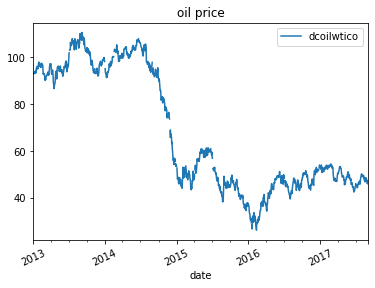

In [6]:
from matplotlib import pyplot as plt
oil_df_indexed = oil_df.set_index('date')
oil_df_indexed.plot(rot=25, title='oil price')
plt.show()

There is a steep drop in oil prices at the end of 2014.

## Correlation

Finally lets see the relation between the oil price and daily sales.

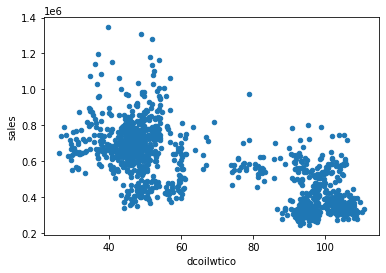

            dcoilwtico     sales
dcoilwtico    1.000000 -0.705002
sales        -0.705002  1.000000


In [11]:
train_df = pd.read_csv(TRAIN_FILE, parse_dates=['date'])

# Create a dataset with daily figures.
daily_figures = train_df.groupby('date').sum()[['sales']]

# Merge left as the daily_figures only contains training dates.
oil_and_sales_df = oil_df.merge(daily_figures, on='date', how='left')
oil_and_sales_df.plot.scatter('dcoilwtico', 'sales')
plt.show()
plt.close()
print(oil_and_sales_df.corr())


There is a negative relation between oil prices and sale volumes (-0.7 pearson), as oil prices increase people perhaps have less to spend on other commodities.
Note that there are some clear clusters in this scatter plot.
